# Sentiment Analysis in Korean (using Naver Sentiment Movie Corpus)
- Count-based method using Logistic Regression
- Dataset source: https://github.com/e9t/nsmc
- To install & use ```Mecab``` tagger in Windows, refer to https://groups.google.com/forum/#!topic/konlpy/SuMc8EkCT_M

In [134]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import Counter

In [73]:
df = pd.read_table("ratings.txt")
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [74]:
mecab = Mecab("C:\\mecab\\mecab-ko-dic")

In [75]:
mecab.morphs(df["document"][0])

['어릴', '때', '보', '고', '지금', '다시', '봐도', '재밌', '어요', 'ㅋㅋ']

In [76]:
%%time
reviews = []
labels = []
all_tokens = []
unique_tokens = dict()

for i in range(len(df)):
    try:
        tokens = mecab.morphs(df["document"][i])
        reviews.append(tokens)
        labels.append(df["label"][i])
        
        all_tokens += tokens
        for t in tokens:
            if t in unique_tokens.keys():
                unique_tokens[t] += 1
            else:
                unique_tokens[t] = 1
    except:
        pass
    
print("Number of Reviews: ", len(reviews), len(labels))
print("Number of tokens: ", len(all_tokens))
print("Number of unique tokens: ", len(unique_tokens))

Number of Reviews:  199992 199992
Number of tokens:  3669567
Number of unique tokens:  61039
Wall time: 23 s


In [77]:
def create_dictionary(unique_tokens, threshold):
    token_to_idx = dict()
    idx_to_token = dict()
    unique_token_keys = list(unique_tokens.keys())
    
    j = 0
    for i in range(len(unique_token_keys)):
        if unique_tokens[unique_token_keys[i]] > threshold:
            token_to_idx[unique_token_keys[i]] = j
            idx_to_token[j] = unique_token_keys[i]
            j += 1
    
    return token_to_idx, idx_to_token

In [78]:
token_to_idx, idx_to_token = create_dictionary(unique_tokens, 1000)

print(len(token_to_idx), len(idx_to_token))

425 425


In [79]:
%%time
for i in range(len(reviews)):
    for j in range(len(reviews[i])):
        if reviews[i][j] in token_to_idx.keys():
            reviews[i][j] = token_to_idx[reviews[i][j]]
        else:
            reviews[i][j] = None
            
    reviews[i] = [x for x in reviews[i] if x != None]

Wall time: 1.97 s


In [81]:
i = 0
for r in reviews:
    if len(r)!=0:
        i += 1
        
print("Number of non-empty reviews: ", i)

Number of non-empty reviews:  197085


In [88]:
X_data = []
y_data = []

for i in range(len(reviews)):
    if len(reviews[i]) != 0:
        temp = np.zeros(len(token_to_idx))
        for t in reviews[i]:
            temp[t] += 1
        X_data.append(temp)
        y_data.append(labels[i])
        
print(len(X_data), len(y_data))

197085 197085


In [94]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X_data), np.asarray(y_data),test_size = 0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(157668, 425) (39417, 425) (157668,) (39417,)


### Logistic Regression with sklearn
- Implementing LR using Scikit-learn
- Cheap & Easy since using high-level API

In [135]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
# Train & Test accuracy of 79%! not so bad!
print("Train Accuracy: ", clf.score(X_train, y_train))
print("Test Accuracy: ", clf.score(X_test, y_test))

Train Accuracy:  0.796788187838
Test Accuracy:  0.797397062181


### Logistic Regression with TF
- Implementing LR using Tensorflow!
- Much more complicated & long, but more low-level & able to try diverse settings

In [121]:
def create_lr_model(X_train, num_epochs = 100, alpha = 0.01, batch_size = 1000):
    W = tf.Variable(tf.random_uniform([X_train.shape[1], 1]))
    b = tf.Variable(tf.random_uniform([1]))
    X = tf.placeholder(tf.float32, shape = [None, X_train.shape[1]])
    Y = tf.placeholder(tf.float32)
    hypo = tf.matmul(X, W) + b
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=hypo, labels=Y))
    adamOptimizer = tf.train.AdamOptimizer(tf.Variable(alpha))
    train = adamOptimizer.minimize(cost)
    
    y_pred = tf.round(tf.sigmoid(hypo))
    y_correct = tf.cast(tf.equal(y_pred, Y), dtype = tf.float32)
    acc = tf.reduce_mean(y_correct)
    return W, b, X, Y, hypo, cost, train, y_pred, y_correct, acc, num_epochs, batch_size

In [143]:
W, b, X, Y, hypo, cost, train, y_pred, y_correct, acc, num_epochs, batch_size = \
                                create_lr_model(X_train, alpha = 0.001, num_epochs = 1000, batch_size = 10000)
cost_trajectory = []
train_accuracy = []
test_accuracy = []

In [144]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(num_epochs):
        batch_idx = np.random.choice(len(X_train), size = batch_size)
        batch_test_idx = np.random.choice(len(X_test), size = 3000)
        batch_X_tr, batch_y_tr = X_train[batch_idx], y_train[batch_idx]
        sess.run(train, feed_dict = {X: batch_X_tr, Y: batch_y_tr})
        temp_cost = sess.run(cost, feed_dict = {X: batch_X_tr, Y: batch_y_tr})
        temp_tr_acc = sess.run(acc, feed_dict = {X: batch_X_tr, Y: batch_y_tr})
        batch_X_te, batch_y_te = X_test[batch_test_idx], y_test[batch_test_idx]
        temp_te_acc = sess.run(acc, feed_dict = {X: batch_X_te, Y: batch_y_te})
        if (i+1) % 10 == 0:
            print("Cost for step {}: {}".format(i+1, temp_cost))
        
        cost_trajectory.append(temp_cost)
        train_accuracy.append(temp_tr_acc)
        test_accuracy.append(temp_te_acc)

Cost for step 10: 4.152773857116699
Cost for step 20: 4.106985092163086
Cost for step 30: 3.9578464031219482
Cost for step 40: 3.992523431777954
Cost for step 50: 3.8413069248199463
Cost for step 60: 3.759780168533325
Cost for step 70: 3.763327121734619
Cost for step 80: 3.7089858055114746
Cost for step 90: 3.705281972885132
Cost for step 100: 3.4980921745300293
Cost for step 110: 3.372502088546753
Cost for step 120: 3.3243536949157715
Cost for step 130: 3.329185962677002
Cost for step 140: 3.293125867843628
Cost for step 150: 3.2670469284057617
Cost for step 160: 3.17498517036438
Cost for step 170: 3.0324788093566895
Cost for step 180: 2.968329906463623
Cost for step 190: 2.8926637172698975
Cost for step 200: 2.8651695251464844
Cost for step 210: 2.719136953353882
Cost for step 220: 2.673672914505005
Cost for step 230: 2.6563050746917725
Cost for step 240: 2.5614233016967773
Cost for step 250: 2.5558314323425293
Cost for step 260: 2.4012701511383057
Cost for step 270: 2.38860869407653

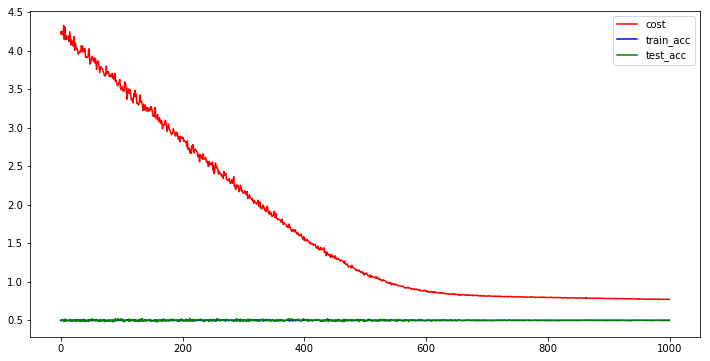

In [146]:
fig = plt.figure(figsize = (12, 6))
plot = fig.add_subplot(111)
plt.plot(np.arange(num_epochs), cost_trajectory, "r", label = "cost")
plt.plot(np.arange(num_epochs), train_accuracy, "b", label = "train_acc")
plt.plot(np.arange(num_epochs), test_accuracy, "g", label = "test_acc")
plt.legend()
plt.show()